In [1]:
import baltic as bt
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from Bio import SeqIO, Seq
from collections import defaultdict
import json
import math
from itertools import combinations, product, izip
import pandas as pd
import numpy as np
from pprint import pprint
from scipy.stats import linregress
from copy import deepcopy

sns.set(style='whitegrid', font_scale = 1.2)

In [22]:
out_path = '../titer_model/rarefaction/rarefaction_n5_output/'
tree_path = '../titer_model/titered_output/titered_tree.json'
reference_path = '../data/reference/genotype_refs_pyke2016.csv'
titer_path = '../titer_model/rarefaction/rarefaction_n5_output/rarefaction_n5_substitution_model.json'
titer_cluster_path = '../titer_model/rarefaction/rarefaction_n5_output/colinear_mutations.txt'

In [23]:
json_translation={'height': 'div', 'name': 'strain'}
tree = bt.loadJSON(tree_path, json_translation)

genotype_strains_path = '../data/reference/strain_genotypes.tsv'
strain_genotypes = pd.read_csv(genotype_strains_path, sep='\t', index_col=None, header=None, names=['strain', 'genotype'])

strain_genotypes = { k['strain'] : k['genotype'] for idx, k in strain_genotypes.iterrows()}

for k in tree.leaves:
    if k.traits['strain'] in strain_genotypes:
        k.traits['genotype'] = strain_genotypes[k.traits['strain']]
        k.traits['serotype'] = strain_genotypes[k.traits['strain']].split('_')[0]
    else:
        print 'annotation not found for ', k.traits['strain']


Tree height: 0.329384
Tree length: 2.129878
strictly bifurcating tree
annotations present

Numbers of objects in tree: 93 (46 nodes and 47 leaves)



In [25]:
antigenic_mutations = json.load(open(titer_path, 'r'))['mutations']
mutation_clusters = [l.strip().split() for l in open(titer_cluster_path, 'r')]

antigenic_clusters = {}
for cluster in mutation_clusters:
    n_antigenic = 0
    
    for mut in cluster:
        if mut in antigenic_mutations:
            antigenic_effect = antigenic_mutations[mut]
            del antigenic_mutations[mut]
            n_antigenic += 1

    assert n_antigenic <= 1
    if n_antigenic == 1:
        antigenic_clusters[tuple(cluster)] = antigenic_effect        

In [14]:
# ofile = open('../titer_model/titered_output/titered_monovalent_output/antigenic_mutations.tsv', 'a')
# for mut, val in antigenic_mutations.items():
#     ofile.write(mut+'\t'+str(round(val,2))+'\n')
# for cluster, val in antigenic_clusters.items():
#     ofile.write(','.join(cluster)+'\t'+str(round(val,2))+'\n')

In [26]:
def get_mutations(seq1, seq2):
    '''
    loops over all translations (listed in self.proteins) and returns a list of
    between as tuples (protein, mutation) e.g. (HA1, 159F)
    '''
    muts = []
    muts.extend(['E:'+aa1+str(pos+1)+aa2 for pos, (aa1, aa2)
                in enumerate(izip(seq1, seq2)) if aa1!=aa2])
    return muts

def get_single_mut_Dij(muts, antigenic_mutations):
    Dij = sum([antigenic_mutations[m] for m in muts if m in antigenic_mutations])
    return Dij

def get_mut_cluster_Dij(muts, antigenic_clusters):
    Dij = 0.
    for cluster, cluster_Dij in antigenic_clusters.items():
        if any([cluster_mut in muts for cluster_mut in cluster]):
            Dij += cluster_Dij
    return Dij

def get_Dij(seq1, seq2, antigenic_mutations=antigenic_mutations, antigenic_clusters=antigenic_clusters):
    muts = get_mutations(seq1, seq2)
    return get_single_mut_Dij(muts, antigenic_mutations) + get_mut_cluster_Dij(muts, antigenic_clusters)

In [27]:
seqs = {s.name : s for s in SeqIO.parse(open('../data/sequences/titered_strains_alignment.mfa', 'r'), 'fasta')}
aa_seqs = {k: Seq.translate(str(v.seq).replace('-', 'N')) for k,v in seqs.items()}

In [28]:
def get_clade_Dij(clade1, clade2, clade_trait='genotype', 
                  tree=tree, aa_seqs=aa_seqs,
                  antigenic_mutations=antigenic_mutations, antigenic_clusters=antigenic_clusters):
    
    clade1_tips = [ k for k in tree.leaves if k.traits[clade_trait] == clade1 ]
    clade2_tips = [ k for k in tree.leaves if k.traits[clade_trait] == clade2 ]
    
    dTiter = 0.
    N_pairs = 0.
    for cl1, cl2 in product(clade1_tips,clade2_tips):
        cl1_seq = aa_seqs[cl1.traits['strain']]
        cl2_seq = aa_seqs[cl2.traits['strain']]
        Dij = get_Dij(cl1_seq, cl2_seq, antigenic_mutations, antigenic_clusters)
        dTiter += Dij
        N_pairs += 1.
        
    return dTiter / N_pairs

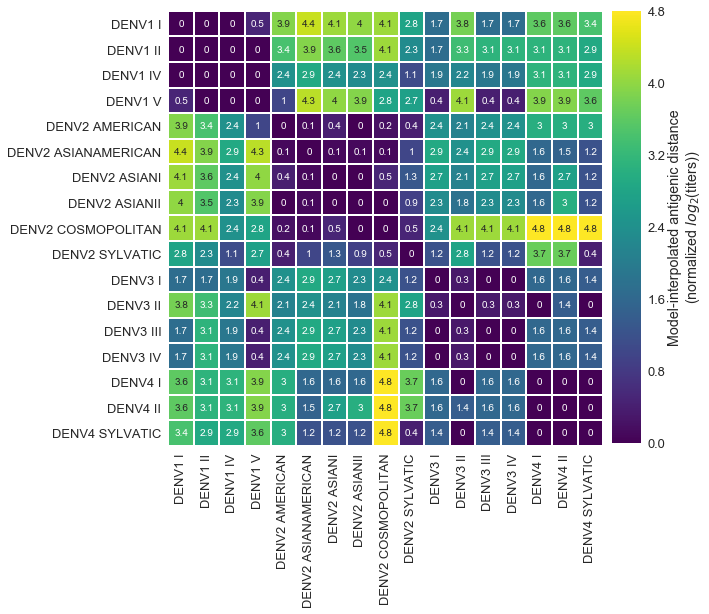

In [29]:
genotypes = set([k.traits['genotype'] for k in tree.Objects if 'genotype' in k.traits])
genotype_distances = defaultdict(dict)
for gt1, gt2 in combinations(genotypes, 2):
    Dij = get_clade_Dij(gt1, gt2, 'genotype')
    genotype_distances[gt1][gt2] = Dij
    genotype_distances[gt2][gt1] = Dij
genotype_distances = pd.DataFrame(genotype_distances)
genotype_distances.fillna(0.,inplace=True)
genotype_distances = genotype_distances.round(1)
genotype_distances.rename(columns={k :k.replace('_', ' ') for k in genotype_distances.columns.values},
                         index={k :k.replace('_', ' ') for k in genotype_distances.columns.values},
                         inplace=True)

fig, ax = plt.subplots(1, 1,figsize=(8,8))
cbar_ax = fig.add_axes([.905, 0.13, .05, .75])

sns.set(font_scale=1.3)
sns.heatmap(genotype_distances, cmap='viridis', annot=True, square=True,
            annot_kws={'fontsize': 10}, linewidths=1, ax=ax, cbar_ax=cbar_ax,
            cbar_kws={'label': r'Model-interpolated antigenic distance'+'\n'+r'(normalized $log_2$(titers))'})

plt.savefig(out_path+'genotype_dTiter_heatmap.png', dpi=300, bbox_inches='tight')

In [30]:
# serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']
# serotype_distances = defaultdict(dict)
# for s1, s2 in combinations(serotypes, 2):
#     Dij = get_clade_Dij(s1, s2, 'serotype')
#     serotype_distances[s1][s2] = Dij
#     serotype_distances[s2][s1] = Dij
# serotype_distances = pd.DataFrame(serotype_distances)
# serotype_distances.fillna(0.,inplace=True)
# serotype_distances = serotype_distances.round(1)
# serotype_distances.rename(columns={k :k.replace('_', ' ') for k in serotype_distances.columns.values},
#                          index={k :k.replace('_', ' ') for k in serotype_distances.columns.values},
#                          inplace=True)

In [31]:
def distances_to_tsv(df, path):
    tsv = open(path, 'w')
    distance_dict = df.to_dict()
    
    for clade1, distances in distance_dict.items():
        for clade2, dist in distances.items():
            tsv.write('\t'.join([clade1, clade2,str(round(dist,2))])+'\n')
    tsv.close()
    
distances_to_tsv(genotype_distances, out_path+'genotype_Dij.tsv')
# distances_to_tsv(genotype_distances, 'titered_serotype_Dij')

In [46]:
def get_nih_vaccine_dTiters(tree, aa_seqs=aa_seqs, 
                            antigenic_mutations=antigenic_mutations, 
                            antigenic_clusters=antigenic_clusters):
    
    NIH_vaccine_strains = {'DENV4': 'DENV4/DOMINICA/814669DELTA30/1981', 
                       'DENV2': 'DENV2/TONGA/DELTA30/1974', 
                       'DENV3': 'DENV3/INDONESIA/SLEMANDELTA30/1978', 
                       'DENV1': 'DENV1/NAURU/WESTERNPACIFICDELTA30/1974'}
    NIH_vaccine_seqs = { sero: aa_seqs[strain] for sero,strain in NIH_vaccine_strains.items()}
    
    for k in tree.leaves:
        k_seq = aa_seqs[k.traits['strain']]
        
        for sero, vaccine_seq in NIH_vaccine_seqs.items():
            Dij = get_Dij(k_seq, vaccine_seq, antigenic_mutations, antigenic_clusters)
            k.traits['%s_vaccine_dTiter'%sero] = Dij
            
    return tree

tree = get_nih_vaccine_dTiters(tree)

In [51]:
for k in tree.Objects:
    k.traits['clade'] = str(k.traits['clade'])
tree_string = tree.toString(traits=['clade', 'genotype', 'serotype', 
                                        'DENV1_vaccine_dTiter', 'DENV2_vaccine_dTiter', 
                                         'DENV3_vaccine_dTiter', 'DENV4_vaccine_dTiter',
                                        'aa_muts'], numName=True, nexus=True)
open(out_path+'trees/titered_annotated_tree.nexus', 'w').write(tree_string)